In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as hr
import dionysus as d
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from src.tda import ClutchMapper, visualize_complex
from src.data_pipeline import query_avg, query_week
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

plt.style.use('ggplot')

init_notebook_mode(connected=True)

In [2]:
df = query_avg("HAVING position = 'LB'")
df = df.iloc[:100]

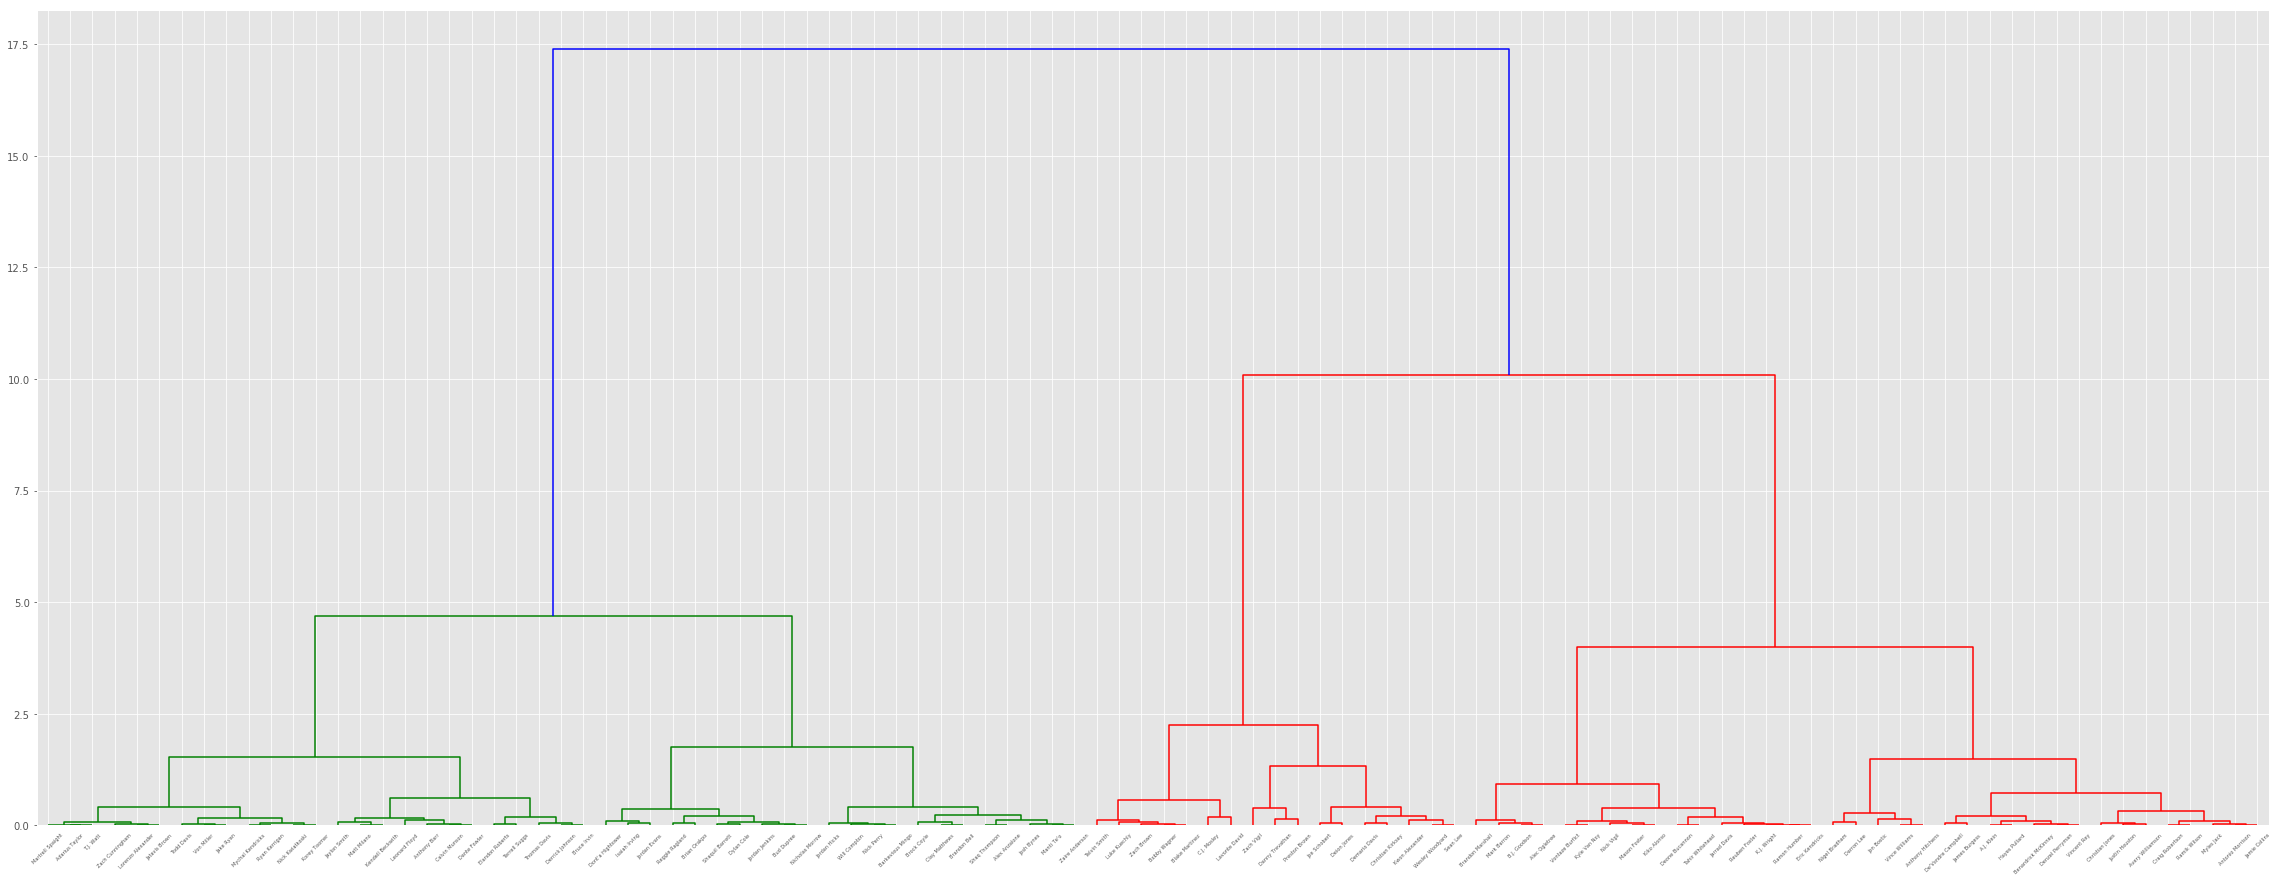

In [3]:
X = df['avg_points'].values.reshape(-1,1)
dist_vector = pdist(X, metric='euclidean')
linkage_mat = hr.linkage(dist_vector, method='ward')
plt.figure(figsize=(40,15));
dendrogram = hr.dendrogram(linkage_mat, labels=df['name'].values);
plt.xticks(rotation=45);
plt.savefig('../plots/lb_dendrogram.png');

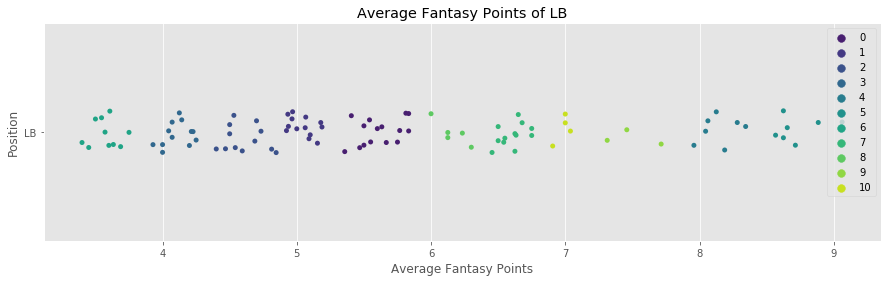

In [4]:
agg = AgglomerativeClustering(n_clusters=11, linkage='ward')
labels = agg.fit_predict(X)

plt.figure(figsize=(15,4));
plt.title('Average Fantasy Points of LB');
sns.stripplot(x="avg_points", y="pos", data=df, hue=labels, palette='viridis', jitter=True);
plt.xlabel('Average Fantasy Points');
plt.ylabel('Position');
plt.savefig('../plots/lb_avg_scatter.png');

In [5]:
stats = df.iloc[:,4:].values

scaler = StandardScaler()
scaled_stats = scaler.fit_transform(stats)

cmapper = ClutchMapper()
cmapper.fit(scaled_stats, labels)

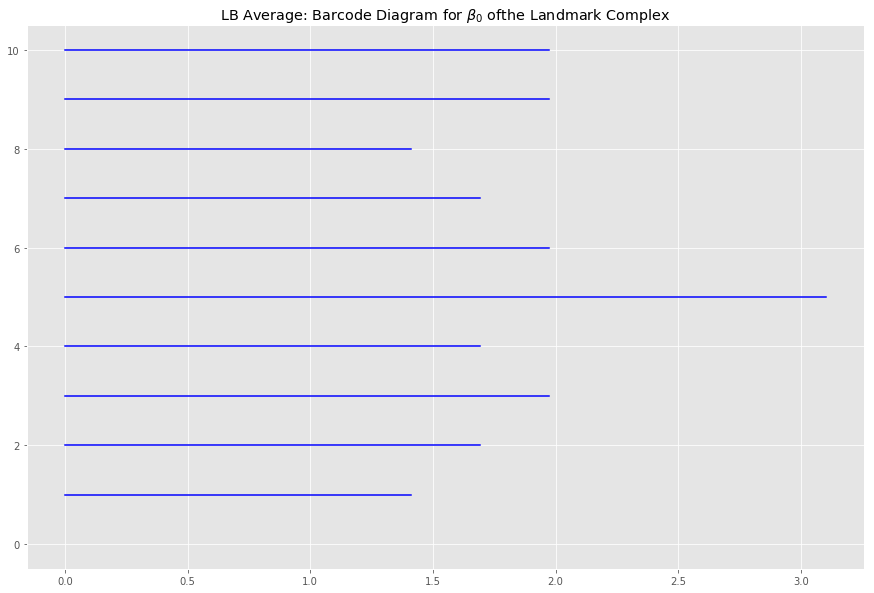

In [6]:
landmark_f, observer_f = cmapper.build_filtrations()

ph = d.homology_persistence(landmark_f)
dgms = d.init_diagrams(ph, landmark_f)

barcode_0 = plt.figure(figsize=(15,10));
plt.title('LB Average: Barcode Diagram for $\\beta_0$ ofthe Landmark Complex');
d.plot.plot_bars(dgms[0], show = True)
barcode_0.savefig('../plots/lb_avg_barcode_landmark.png');

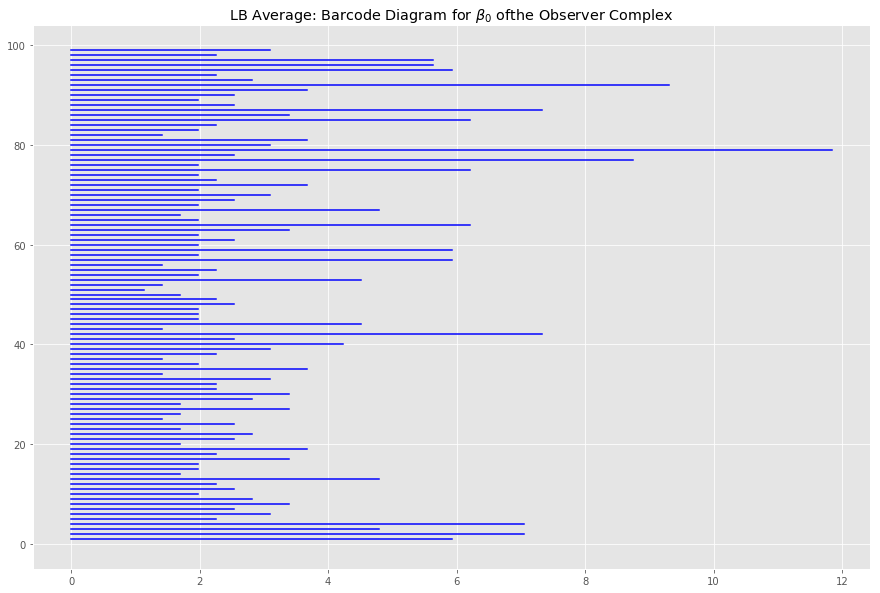

In [7]:
ph = d.homology_persistence(observer_f)
dgms = d.init_diagrams(ph, observer_f)

barcode_1 = plt.figure(figsize=(15,10));
plt.title('LB Average: Barcode Diagram for $\\beta_0$ ofthe Observer Complex');
d.plot.plot_bars(dgms[0], show = True)
barcode_1.savefig('../plots/lb_avg_barcode_observer.png')

In [8]:
import pymongo

client = pymongo.MongoClient()
db_name = 'nfl'
db = client[db_name]
collection_name = 'complexes'
COMPLEXES = db[collection_name]
COMPLEXES.create_index([('name', pymongo.ASCENDING)], unique=True)

names = list(df['name'].values)

for i in np.arange(0,10.1,0.5):
    landmark_complex, observer_complex = cmapper.build_complex(i)

    landmark_fig = visualize_complex(landmark_complex, 'LB Average: Landmark Complex at t={}'.format(i))
    observer_fig = visualize_complex(observer_complex, 'LB Average: Observer Complex at t={}'.format(i), names)
    
    landmark_json = landmark_fig.to_plotly_json()
    observer_json = observer_fig.to_plotly_json()
    
    landmark_json['name'] = 'lb_avg_landmark_complex_{}'.format(i)
    observer_json['name'] = 'lb_avg_observer_complex_{}'.format(i)
    
    COMPLEXES.insert_one(landmark_json)
    COMPLEXES.insert_one(observer_json)